Данную задачу я получил в авральном режиме. Заказчику нужны были данные срочно, срок был ограничен двумя днями. 


Задача:
Сравнить LTV общей школы и договора.
Зачем?
Чтобы рассчитывать бюджет и понимать рентабельность продукта


Проблема: 
LTV общей школы рассчитан при помощи фита рациональной и показательной функции cash-in когорт по дням.
Поступления от контрактников, особенно в разрезе когорт, не описываются ни рациональной, ни показательной функцией. 

<img src="newplot (14).png">

Когорты вообще ведут себя очень по-разному.

Вот этот график из вот этого отчета https://app.redash.io/skyeng/queries/96081 даёт понимание о том, почему так происходит

<img src="newplot (15).png">

Студенты от компаний продолжают приходить и через 200 и через 300 и черезз 1000 дней после первого студента. В итоге, каждая месячная когорта содержит в себе студентов их разных компаний. И в какую-то когорту попадают волны новых студентов от крупного клиента, а в какую-то нет.

То есть применить тот же метод рассчета, которым пользовался Глеб при расчете LTV общей школы не получится

Однако сравнить очень нужно, поэтому!

Решение:
Оплаты-то от студентов по договору идут непонятно как, но учатся они примерно так же. Тоже отваливаются после какого-то занятия.
Попробуем сравнить лайфлайм договора и общей школы через кривые ретенш. 

Как уже писал Ваня Кононов, сумма всех целочисленных значений поурочного ретеншена по сути и есть LT. Вот его-то мы и посчитаем

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#загружаем данные из вот этого отчета: https://app.redash.io/skyeng/queries/101302
#отчет выгружает данные контрактников или общей школы, в зависимости от того, что закоментировано на 470-472 строчке
intencity_adult = pd.read_csv('rets_adult_int.csv',index_col=0)
intencity_contract = pd.read_csv('rets_contract_int.csv',index_col=0)
intencity_contract.sort_index(inplace=True)
intencity_adult.sort_index(inplace=True)

#Тут интенсивность рассчитана как среднее количество дней на один урок.
intencity_contract[['avg_intencity', 'cohort_size']].describe()

#Посмотрим на когорты

,avg_intencity,cohort_size
count,30.000000,30.000000
mean,6.244124,303.566667
std,1.551633,268.032639
min,1.894308,36.000000
25%,5.609067,92.500000
50%,6.145910,215.000000
75%,7.176941,398.500000
max,9.505008,1030.000000


In [9]:
intencity_adult[['avg_intencity', 'cohort_size']].describe()

,avg_intencity,cohort_size
count,31.000000,31.000000
mean,6.202518,1388.645161
std,1.713867,772.116336
min,0.071429,7.000000
25%,5.975298,711.500000
50%,6.588676,1224.000000
75%,7.070055,1903.000000
max,8.052704,3130.000000


Дальше будет очень хитрая магия. 

Заказчик очень попросил учесть дисконтирование, так как предполагал, что у студентов по договору позже начинается падение ретеншен, и это сыграет в пользу увлечиения LTV договорных ребят.

Беда в том, что фактически, то, когда проходят уроки и то, когда их оплатили это две не особо явно связанные вещи. Но, так как времени не было, было принято решение не обращать внимание на этот фактор и считать, что каждый урок оплачивается в момент проведения. 

План таков: берем дисконтирование 30% или 1-0.999023 в день. Соответственно коэфициент дисконтирования для каждого урока будет равен 0.999023 в степени равной количесту дней после старта отсчета, от которого мы считаем дисконирование.

In [10]:
ans = []
for j in intencity_adult['avg_intencity']:
    lst = []
    for i in range(299):
        lst.append( 0.999023**(i*j))
    ans.append(lst)

to_m = pd.DataFrame(ans)
adult_disc =  intencity_adult.drop(['cohort_size', 'avg_intencity'],axis=1).multiply(to_m.values)
adult_disc['cohort_size']=intencity_adult['cohort_size']

In [11]:
ans = []
for j in intencity_contract['avg_intencity']:
    lst = []
    for i in range(299):
        lst.append( 0.999023**(i*j))
    ans.append(lst)

to_m = pd.DataFrame(ans)
contract_disc =  intencity_contract.drop(['cohort_size', 'avg_intencity'],axis=1).multiply(to_m.values)
contract_disc['cohort_size']=intencity_contract['cohort_size']

А теперть посмотрим на графики поурочного ретеншена у когорт общей школы и корпов. Я вывожу только самые средние, не старые и не слишком молодые когорты

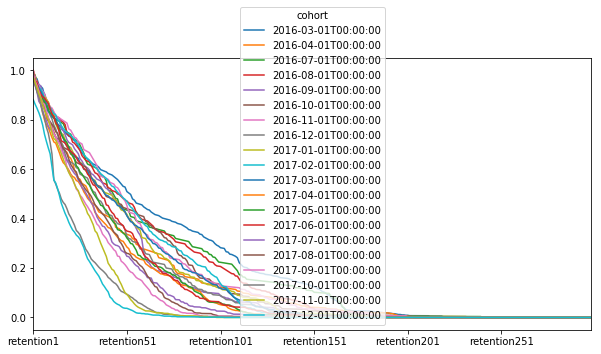

In [12]:
contract_disc = contract_disc[contract_disc['cohort_size']>60].head(20)

contract_disc.drop('cohort_size', axis=1).T.plot(figsize=(10,5))
contract_disc['FactLT'] = contract_disc.drop('cohort_size', axis=1).sum(axis=1)

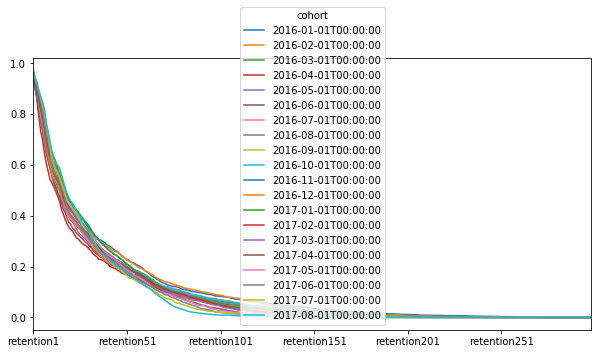

In [13]:
adult_disc = adult_disc[adult_disc['cohort_size']>60].head(20)

adult_disc.drop('cohort_size', axis=1).T.plot(figsize=(10,5))
adult_disc['FactLT'] = adult_disc.drop('cohort_size', axis=1).sum(axis=1)


Общая школа ведет себя очень законопослушно. Все в целом одинаково. Договор опять ведет себя по-разному. Но тем ни менее что-то посчитать нужно:) Поэтому мы с заказчиком договорились, что я посмотрю фактический LT по кривой ретеншн, расчитанный одинаковым образом для договора и для общей школы. Тут не будет апроксимировать, просто сумма целочисленных значений кривых ретеншн. 

In [14]:
adult =  adult_disc['FactLT'].tail(18)
adult = adult.tail(14)
contract =  contract_disc['FactLT'].head(16).tail(14)
Compare = pd.DataFrame(contract)
Compare['adult'] = adult
Compare.columns = ['contract LT', 'adult LT']
Compare['coef'] = Compare['contract LT']/Compare['adult LT']
Compare
Compare['coef'].sum()/14

1.6134895672980325

In [15]:
Compare

,contract LT,adult LT,coef
cohort,,,
2016-07-01T00:00:00,60.473544,29.835678,2.026887
2016-08-01T00:00:00,56.824246,30.390832,1.869783
2016-09-01T00:00:00,45.793421,28.839872,1.587851
2016-10-01T00:00:00,50.477113,31.244025,1.615576
2016-11-01T00:00:00,53.593295,28.053332,1.910407
2016-12-01T00:00:00,42.609772,27.384184,1.555999
2017-01-01T00:00:00,47.781473,30.486591,1.567295
2017-02-01T00:00:00,51.765675,28.770665,1.799252
2017-03-01T00:00:00,47.723025,27.616607,1.728055


Получается в среднем вот такая история. Средний коэфициент равен 1.61, но коэфициент, как и средний LT весьма заметно пляшет. И вообще расчитан на старых когортах. Так что надо двигаться дальше.

Идея:

Я не просто так поместил в начало ноутбука график притока новых студентов от компаний и написал о том, что вообще-то важно из какой именно компании студент. 
Мне кажется было бы разумным изучать наш продукт разбивая когорты не по месяцам, а по компаниям. Ну или разряду компаний, можно же выделять похожие компании в сегменты. Внизу график, построенный по компаниям

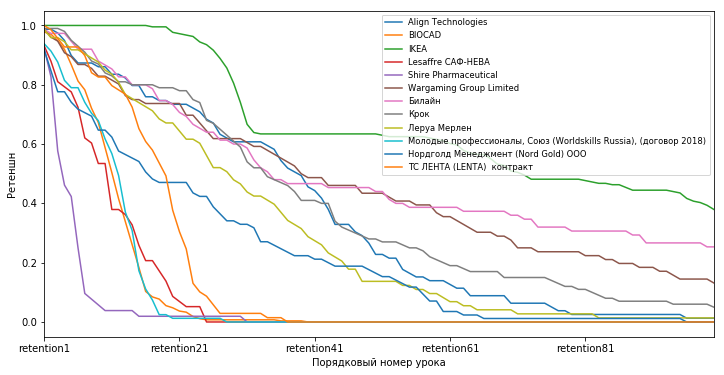

In [46]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

comp = pd.read_csv('rets_comps_inten.csv',index_col=0)
comp = comp.sort_index()
comp = comp[comp['cohort_size']>50].head(15)
comp.drop('cohort_size', axis=1).T.plot(figsize=(12,6))
plt.xlabel('Порядковый номер урока')
plt.ylabel('Ретеншн')
plt.legend(prop=fontP)
comp['FactLT'] = comp.drop('cohort_size', axis=1).sum(axis=1)



Что видно на графике:
Компании ведут себя по-разному. И это естестенно. Кто-то(BIOCAD и Молодые профессионалы...) покупают некий пакет уроков, около 10 и учится. Кривая резко падает. Кто-то учится много и долго (Ikea, Билайн). 

В общем, расчет основных метрик по компаниям, а не по студентам и когортам кажется более естественным. Одна беда: заказчик постулирует то, что нам нужно сравнивать себя с общей школой.

In [28]:
comp['FactLT'] 

cohort
Align Technologies                                                  36.139241
BIOCAD                                                              10.525735
IKEA                                                                67.157407
Wargaming Group Limited                                             46.263158
Билайн                                                              49.866667
Крок                                                                39.250000
Леруа Мерлен                                                        30.027397
Молодые профессионалы, Союз (Worldskills Russia), (договор 2018)    10.111111
Нордголд Менеджмент (Nord Gold) ООО                                 22.800000
ТС ЛЕНТА (LENTA)  контракт                                          16.608696
Name: FactLT, dtype: float64